# Notebook for Decomposing High-Density Surface EMG

## Installing Library for Interactive Plots

You should run the code cell below to enable interactive plots. If you run it, you must wait until the runtime restarts, as we are installing a library (`ipympl`). Afterward, you can execute all other cells.

Note: "Run all" cells won't be executed successfully because the code `os.kill(os.getpid(), 9)` restarts the runtime.

If you don't need interactive plots, you can comment or delete the first code cell. Additionally, you should do the same for the commands `%matplotlib widget` and `output.enable_custom_widget_manager()` in the second code cell. If you make these changes, the "Run all" option will work correctly.

In [1]:
import os
!pip install ipympl
os.kill(os.getpid(), 9)

## Cloning the GitHub Repository and Importing Libraries

In [50]:
!git clone -l -s https://github.com/MateusASchneiderCastilhos/EMG_Crosstalk_Decomposition_Workshop cloned-repo
%cd cloned-repo

from dependencies import content
from google.colab import output
import ipywidgets as ipywi
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from sklearn.cluster import KMeans

# Enabling interactive graphs plots
%matplotlib widget
output.enable_custom_widget_manager()

# Defining some default configurations to plot the graphs
plt.rcParams.update(
    {
        "axes.spines.top" : False,
        "axes.spines.right" : False,
        "font.size": 12,
    }
)

Cloning into 'cloned-repo'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 187 (delta 4), reused 10 (delta 3), pack-reused 173
Receiving objects: 100% (187/187), 43.63 MiB | 32.78 MiB/s, done.
Resolving deltas: 100% (80/80), done.
/content/cloned-repo/cloned-repo


## Importing HD sEMG Files and Identifying Bad Channels

### Importing HD sEMG File

Defining the `import_Mat_file()` Function

The `import_Mat_file()` function is responsible for importing HD sEMG signals saved as `.mat` files. Below are some considerations about the expected structure of the data for this function to work.

The `.mat` file must be saved as a dictionary, as shown below. While there can be additional keys and values in this dictionary, the main keys are expressed here. Inside the list corresponding to the "Data" key, there is a matrix representing the HD sEMG data. Ideally, the rows of this matrix should represent EMG channels, and the columns should represent the sampled data. However, if this is not the case, the `import_Mat_file()` function can identify the orientation of the matrix and reshape it accordingly. The function provides information about the sampling frequency, time, and EMG samples.

```python
{
    "SamplingFrequency": [2048],
    "Time": [[0.0, 0.1, ..., 50]],
    "Data": [[
                [0.2, 1.0, ..., 38.2],
                [-0.5, -5.0, ..., 70.6],
                ...,
                [1.3, 5.6, ..., -54.8]
            ]]
}
```

Now, we define a function that imports the HD sEMG data. We will import the HD sEMG signals stored in the data directory. To change the selected file, go to the last line of code and replace EMG_S1_05.mat with the actual file name.

In [51]:
def import_Mat_file(filePath: str):
    """
    Imports High-Density (HD) sEMG signals saved as a '.mat' file.

    Parameters:
    - filePath (str): The path to the '.mat' file with the filename with/without the extension.

    Returns:
    - f_sampling (float): Sampling frequency of the sEMG signals.
    - time_samples (numpy.ndarray): Array containing the time samples of the sEMG data.
    - sEMG (numpy.ndarray): Matrix containing the HD sEMG data. Rows represent EMG channels, and
                            columns represent the sampled data.

    Notes:
    - The '.mat' file must be saved as a dictionary with specific keys:
        - 'SamplingFrequency': Array containing the sampling frequency.
        - 'Time': 2D array containing the time samples.
        - 'Data': 2D array containing the HD sEMG data.

    - The function reshapes the data matrix if needed to ensure consistent channel and time orientation.
    """

    if filePath[-4:] != ".mat":
        filePath = "".join([filePath, ".mat"])

    matFile = scio.loadmat(filePath)

    f_sampling = matFile["SamplingFrequency"][0, 0]
    time_samples = matFile["Time"][0, 0].reshape(-1)
    sEMG = matFile["Data"][0, 0]

    if sEMG.shape[1] < sEMG.shape[0]:
        sEMG = sEMG.T

    return f_sampling, time_samples, sEMG

f_sampling, time_samples, sEMG = import_Mat_file("EMG and Force Data/WorkshopData/EMG_S1_05.mat")

### Identifying Bad Channels (Visually)

Here, you will visualize the plotted HD sEMG signals and have the ability to deselect channels considered "bad" due to motion artifacts. Only the selected channels will be considered in the decomposition processing. Below, we are defining several functions responsible for displaying checkboxes in a spatial format matching the electrode matrix used to record the HD sEMG signals. Two key functions are introduced:

* `def_grid()`: This function takes the identification of the electrode matrix used during recording and creates an array where each element corresponds spatially to the respective channel in the electrode grid. For the pinout of the grids, refer to this [link](https://drive.google.com/file/d/1qddoypRMnP4R74OrSoXDmdO3SJUynQZk/view?usp=share_link);

* `channels_selection()`: This function provides interactive widgets (checkboxes) displayed in a spatial location corresponding to the surface grid used during the recording of HD sEMG signals. Additionally, this function is responsible for keeping the list of selected (checkbox checked) or unselected channels updated. Only the selected channels are used in the decomposition processing;

* `plot_channels()`: This function plots the HD sEMG signals for channels checked in the matrix of checkboxes generated earlier. Before plotting, the function computes a scale factor based on the mean and standard deviation of the channels. This scale factor rescales all HD sEMG signals to avoid overlapping curves in the plot;

* `def_badChannels()`: This function identifies channels that are not selected (checkbox not checked) and stores their indexes. These bad channels need to be saved after the decomposition because we need to know which channels were not considered for the afferent procedure (Hands-on 2 of this workshop);

In [52]:
def def_grid(grid_name):
    """
    Defines the electrode grid based on the specified grid name.

    Parameters:
    - grid_name (str): The name of the electrode grid.

    Returns:
    - grid (numpy.ndarray): An array representing the spatial arrangement of electrodes in the grid.
    """

    if grid_name.upper() == "ELSCH064NM4":
        a = np.arange(60, 65, dtype=int)
        grid = np.array([a, (a - 5)[::-1], a - 10, (a - 15)[::-1], a - 20, (a - 25)[::-1],
                         np.array([32, 31, 30, 33, 34], dtype=int), (a - 35)[::-1], a - 40,
                         (a - 45)[::-1], a - 50, (a - 55)[::-1], a - 60], dtype=int)
    return grid

def channels_selection(grid):
    """
    Creates interactive checkboxes for channel selection based on the provided electrode grid.

    Parameters:
    - grid (numpy.ndarray): The electrode grid array.

    Returns:
    - checkboxes (ipywidgets.VBox): An interactive widget containing checkboxes in a spatial layout.
    - checked_channels (dict): A dictionary mapping channel numbers to their respective checkboxes.
    """

    aux = []
    my_matrix = []
    checked_channels = {}

    i, j = grid.shape

    for row in range(i):
        aux = []
        for col in range(j):
            ch = grid[row, col]
            if ch != 0:
                check = ipywi.Checkbox(value=True, description=str(grid[row, col]), indent=False)
                checked_channels['ch' + str(ch)] = check
                aux.append(check)
            else:
                check = ipywi.Checkbox(value=False, description='', indent=False, disabled=True)
                check.layout.visibility = 'hidden'
                aux.append(check)

        my_matrix.append(ipywi.HBox(aux, layout=ipywi.Layout(width='25%')))

    return ipywi.VBox(my_matrix), checked_channels

def plot_channels(checked_channels):
    """
    Plots HD sEMG signals for selected channels.

    Parameters:
    - checked_channels (dict): A dictionary mapping channel numbers to their respective checkboxes.

    Returns:
    - None
    """

    x = sEMG.mean(axis=1)

    try:
        indexes = np.unique(
            np.array([np.argwhere(x < x.mean() + 3 * x.std(ddof=1)).reshape(-1),
                      np.argwhere(x > x.mean() - 3 * x.std(ddof=1)).reshape(-1)]))
        max_amp = 0
        for i in sEMG[indexes, :]:
            if abs(i.max() - i.min()) > max_amp:
                max_amp = abs(i.max() - i.min())
        x = sEMG * 2 / max_amp
    except:
        x = sEMG / 3

    channels = [int(ii.description) for ii in checked_channels.values() if ii.value]
    channels = np.sort(np.array(channels).astype(int))

    color_markers = plt.cm.gist_rainbow(np.linspace(0, 1, sEMG.shape[0]))
    c_len = len(color_markers)

    fig, (lax, ax) = plt.subplots(figsize=(17, 15), nrows=2, gridspec_kw={"height_ratios": [1, 20]})

    for i in channels:
        ax.plot(time_samples, i + x[i - 1, :], c=color_markers[int(i % c_len)], label="Ch " + str(i))

    plt.suptitle('Selected HD sEMG Channels', fontsize=14)
    plt.xlabel('Time (s)')
    plt.ylabel('EMG Channel')

    h, l = ax.get_legend_handles_labels()
    lax.legend(h, l, loc='center', borderaxespad=0, ncol=8)
    lax.axis("off")

def def_badChannels(checked_channels):
    """
    Identifies and returns the indices of channels that are not selected (unchecked).

    Parameters:
    - checked_channels (dict): A dictionary mapping channel numbers to their respective checkboxes.

    Returns:
    - bad_channels (numpy.ndarray): An array containing the indices of channels that are not selected.
    """
    
    selected_channels = [int(ii.description) for ii in checked_channels.values() if ii.value]
    bad_channels = np.argwhere(np.isin(np.arange(sEMG.__len__(), dtype=int),
                                       np.sort(np.unique(selected_channels)).astype(int), invert=True)).reshape(-1)

    return bad_channels

**Instructions:**
1. Run both code cells below to display the grid of checkboxes and the plot of the HD sEMG signals.
2. Identify any bad channels from the graph, i.e., channels that exhibit motion artifacts. There may be several or none.
3. To mark a channel as bad, click the checkbox corresponding to that channel.
4. Any unchecked checkboxes are considered bad channels and will not be included during the decomposition process.


In [53]:
ui1, choosed_channels = channels_selection(def_grid("elsch064NM4"))

display(ui1)

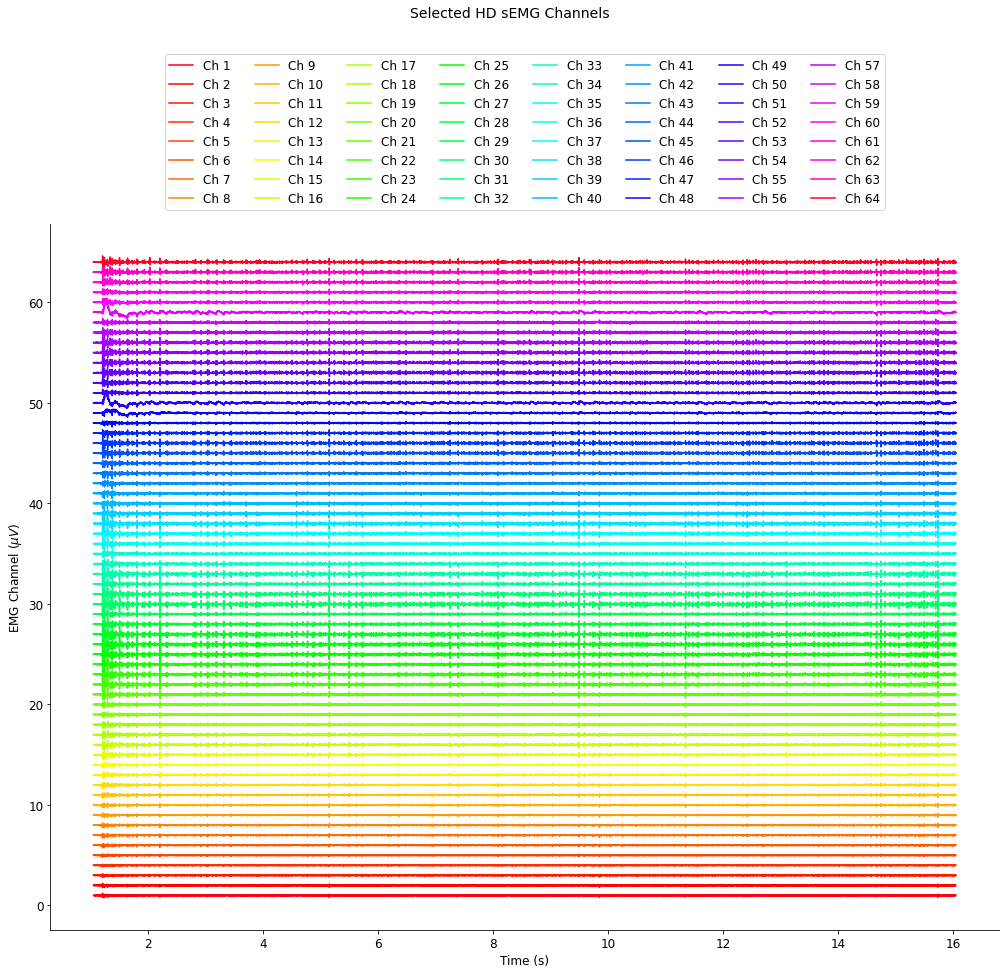

In [54]:
plot_channels(choosed_channels)

## Pre-processing and Decomposing the HD sEMG Signals

### Defining the Interactive Menu Widgets for Decomposition

Below, we have defined some widgets that will help you set the parameters of the FastICA algorithm. You should not worry about the code below because it is not part of the decomposition itself; you just need to run it to interact better. Here's a brief explanation:

- `menu_parameters()`: This function provides five text input widgets (only numbers allowed) where you can define the values of these parameters. There are upper and lower bounds specified for each widget, and these bounds are presented before the text input. Additionally, there are two selection widgets with several options for parameters, but you can choose only one. Lastly, there is a progress bar widget that shows "how much time" has passed after starting the decomposition.

In [55]:
decompose_bar_progess = ipywi.IntProgress()

def menu_parameters(n_channels:int):
    """
    Creates interactive widgets for setting parameters of the FastICA algorithm.

    Parameters:
    - n_channels (int): Number of channels in the HD sEMG signals.

    Returns:
    - List of ipywidgets representing the interactive parameters:
        - BoundedIntText: Number of Iterations (M) [1 - 500]
        - BoundedIntText: Extension Factor (R) [4 - 32]
        - BoundedIntText: Internal Loop Iterations [20 - 60]
        - BoundedFloatText: FastICA Convergence [10ˉ⁵ - 10ˉ²]
        - BoundedFloatText: SIL Threshold (SIL [%]) [0 - 100]
        - RadioButtons: Contrast Function g(x)
        - RadioButtons: Initializations of wⱼ
    """

    global decompose_bar_progess

    style = {'description_width': 'initial'}
    
    w_M = ipywi.BoundedIntText(min = 1, max = 500, step = 1, value = 120, description='Number of Iterations (M) [1 - 500]: ',style=style)
    w_R = ipywi.BoundedIntText(min = 4, max = 32, step = 1, value = 10, description='Extension Factor (R) [4 - 32]: ',style=style)
    w_in = ipywi.BoundedIntText(min = 20, max = 60, step = 1, value = 30, description='Internal Loop Iterations [20 - 60]: ',style=style)
    w_Tolx = ipywi.BoundedFloatText(min = 0.00001, max = 0.01, step = 0.000001, value = 0.0023, description='FastICA Convergence [10ˉ⁵ - 10ˉ²]: ',style=style,readout_format='.6f')
    w_Sil = ipywi.BoundedFloatText(min = 0, max = 100, step = 0.1, value = 90, description='SIL Threshold (SIL [%]) [0 - 100]: ',style=style, readout_format='.1f')

    w_cf = ipywi.RadioButtons(
        description='Contrast Function g(x):',
        options=[
            'x²',
            'x³',
            '(-x) exp(-x² / 2)',
            'log(x² + 1)',
            'tanh(x)',
        ],
        layout={'width': 'max-content'},
    )

    w_winit = ipywi.RadioButtons(
        description='Initializations of wⱼ:',
        options=[
            'Maximum',
            'Median',
            '81th Percentile',
            'Random',
        ],
        layout={'width': 'max-content'},
    )

    decompose_bar_progess = ipywi.IntProgress(
            value=0,
            min=0,
            max=w_M.value,
            bar_style='success',
            orientation='horizontal',
        )

    ll1 = ipywi.link((w_M, 'value'),(decompose_bar_progess, 'max'))

    return [w_M,w_R,w_in,w_Tolx,w_Sil,w_cf,w_winit]

### Definig the Contrast Functions

Here, we define five classes that contain distinct contrast functions for use in the decomposition process. These functions serve as cost functions used to compute the approximate negentropy. The defined functions are expressed below, but it's important to note that the algorithm utilizes their first and second derivatives. Equation (1) was suggested in [(NEGRO et al., 2016)](#scrollTo=references), equation (3) in [(HOLOBAR; ZAZULA, 2008)](#scrollTo=references), and equations (2), (4), and (5) were suggested in [HYVÄRINEN (1999)](#scrollTo=references).

$$ G(x) = \frac{x^3}{3} \quad (1) $$

$$ G(x) = \frac{x^4}{4} \quad (2) $$

$$ G(x) = x \text{ } ln(x^2 + 1) + 2 [tan^{-1}(x) - x] \quad (3)$$

$$ G(x) = ln(cosh(x)) \quad (4) $$

$$ G(x) = exp \Big( \frac{- x^2}{2} \Big) \quad (5) $$

In [56]:
class Squared_CF:
    # G(x) = x^3/3
    @staticmethod
    def g(w: np.ndarray) -> np.ndarray:
        return w * w

    @staticmethod
    def dg_dw(w: np.ndarray) -> np.ndarray:
        return 2 * w

class Skewness_CF:
    # G(x) = x^4/4
    @staticmethod
    def g(w: np.ndarray) -> np.ndarray:

        return w * w * w

    @staticmethod
    def dg_dw(w: np.ndarray) -> np.ndarray:
    
        return 3 * w * w

class Log_CF:
    # G(x) = x log(x^2 + 1) + 2 (arctan(x) - x) where log() is the natural logarithm
    @staticmethod
    def g(w: np.ndarray) -> np.ndarray:
        # If is desired use logarithms in another base, by example, in base 10, then the return must be:
        # return np.log(w * w +1) / np.log(10) # equals to np.log(w * w +1) / 2.302585092994046
        return np.log(w * w +1)

    @staticmethod
    def dg_dw(w: np.ndarray) -> np.ndarray:
        # If is desired use logarithms in another base, by example, in base 10, then the return must be:
        # return 2 * w / (w * w +1) / np.log(10)
        return 2 * w / (w * w +1)

class Tanh_CF:
    # G(x) = log(cosh(x))
    @staticmethod
    def g(w: np.ndarray) -> np.ndarray:
        # If is desired use logarithms in another base, by example, in base 10, then the return must be:
        # return np.tanh(w) / np.log(10)
        return np.tanh(w)

    @staticmethod
    def dg_dw(w: np.ndarray) -> np.ndarray:
        # If is desired use logarithms in another base, by example, in base 10, then the return must be:
        # return (1 - np.square(np.tanh(w))) / np.log(10)
        return (1 - np.square(np.tanh(w)))


class ExpSquared_CF:
    # G(x) = exp(- x^2 / 2)
    @staticmethod
    def g(w: np.ndarray) -> np.ndarray:
        return (-w) * np.exp((-1 / 2) * w * w)

    @staticmethod
    def dg_dw(w: np.ndarray) -> np.ndarray:
        return ((w * w) - 1) * np.exp((-1 / 2) * w * w)

### Decomposition Quality Measures

During the decomposition process, some metrics about the quality of the estimated sources are needed to determine if the estimation is good or not. These metrics use temporal information about when a motor unit has discharged and utilize the values of the estimated motor unit action potential trains at these time instants to determine how distinct these values are from the baseline noise. There are two main metrics that can be used: the modified silhouette measure (SIL), used in [(NEGRO et al., 2016)](#scrollTo=references), and the pulse-to-noise ratio (PNR) defined in [(HOLOBAR; MINETTO; FARINA, 2014)](#scrollTo=references).

So, the `PT_metrics()` function below is responsible for identifying the time instants of a motor unit action potential (MUAP) in the estimated source signal. Then, using these time instants, the corresponding voltage values of the estimated source signal (source), and the other values of the estimated source (corresponding to noise), the `PT_metrics()` function computes both the SIL and PNR.


In [57]:
def PT_metrics(s_i: np.ndarray, f_s: int) -> Tuple[np.ndarray, float, float]:
    """
    Calculate metrics for the quality of estimated sources.

    Parameters:
    - s_i (numpy.ndarray): Estimated source signal.
    - f_s (int): Sampling frequency.

    Returns:
    - Tuple containing:
        - MUs_timeInst (numpy.ndarray): Time instants of motor unit action potentials.
        - SIL (float): Silhouette measure.
        - PNR (float): Pulse-to-Noise Ratio.
    """

    within_cluster_sum = 1
    betw_clusters_sum = 1
    pnr_numerator = 1
    pnr_denominator = 1

    s_i_squared = s_i * s_i

    peaks_timeInst, _ = find_peaks(s_i_squared, distance=20)

    peaks_squared = s_i_squared[peaks_timeInst]

    kmeans = KMeans(n_clusters=2, init="k-means++", max_iter=400).fit(peaks_squared.reshape(-1, 1))
    centroids = kmeans.cluster_centers_
    peaks_labels = kmeans.predict(peaks_squared.reshape(-1, 1))

    MUs_timeInst = peaks_timeInst[peaks_labels == np.argmax(centroids).astype(int)]

    MUs_timeInst = np.delete(MUs_timeInst, np.argwhere(s_i[MUs_timeInst] < 0).reshape(-1))

    if MUs_timeInst.__len__() > 1:

        if f_s / np.diff(MUs_timeInst).mean() > 2:

            within_cluster_sum = 0
            betw_clusters_sum = 0

            # Getting the parameters to calculate the SIL score
            for i in range(peaks_squared.__len__()):
                within_cluster_sum += np.linalg.norm(peaks_squared[i] - centroids[peaks_labels[i], 0])
                betw_clusters_sum += np.linalg.norm(peaks_squared[i] - centroids[1 - peaks_labels[i], 0])

            # Computing the Pulse to Noise Ratio (PNR)
            pnr_numerator = s_i_squared[MUs_timeInst].mean()
            peaks_labels = np.delete(np.arange(s_i_squared.__len__(), dtype=int), MUs_timeInst)
            pnr_denominator = s_i_squared[peaks_labels].mean()

    return (
        MUs_timeInst,
        abs(within_cluster_sum - betw_clusters_sum) / max(within_cluster_sum, betw_clusters_sum),
        10 * np.log10(pnr_numerator / pnr_denominator),
    )

### Pre-processing and Decomposition Algorithms

Now we perform all pre-processing steps needed for the decomposition: remove the selected bad channels, extend the HD sEMG signals, center the signals, and apply PCA and whitening. The `decompose()` function handles all the previously mentioned processes except for bad channels removal. This is because we created an interactive widget block (`menu_parameters()` function) for you to choose the parameters of the algorithm. After setting the parameters, the widget block passes all the parameter values to just one function.

The extension of the HD sEMG signals is a strategy to increase the number of observations and, theoretically, the number of estimated sources. This process generates R versions of each HD sEMG signal, with delays ranging from 1 to R. Refer to [Figure 1](#figure_1) for a better understanding.

<a name='figure_1'></a>
<figure align="center"><img src="https://github.com/MateusASchneiderCastilhos/EMG_Crosstalk_Decomposition_Workshop/blob/main/assets/Extension.png?raw=1" width="500"/><figcaption align="center"> Figure 1 - Representation of the extension procedure (an exaggerated representation for didactic purposes).</figcaption></figure>

Another important term used in the implementation of the algorithm presented here is the activity index, a global indicator of motor unit discharge activity introduced in [(HOLOBAR; ZAZULA, 2007)](#scrollTo=references). The study by [NEGRO et al. (2016)](#scrollTo=references) suggests setting the start point of the FastICA algorithm based on this activity index. Thus, the present algorithm uses four possible initial start points based on the activity index, as follows:

1. Based on the argument of the activity index that corresponds to its maximum value. This choice was made considering the study by [NEGRO et al. (2016)](#scrollTo=references);

2. Based on the argument of the activity index that corresponds to its median value. This choice was made considering the study by [HOLOBAR and ZAZULA (2007)](#scrollTo=references);

3. Based on the argument of the activity index that corresponds to its 81st percentile value. This choice was made considering some previous decompositions done by us (data not published);

4. Based on the argument of the activity index that corresponds to a random percentile value. This choice was made as an alternative to the study by [HYVÄRINEN (1999)](#scrollTo=references), which suggests just a random initialization, not based on some indicator;

In [58]:
# Defining the bad channels to be removed
bad_channels = def_badChannels(choosed_channels)

def decompose(M, RR, max_iter, Tolx, SIL, contrastF, w_init):
    
    # Defining the global variables that will be modified inside this function
    global B, extracted_PTs, Sil, PNr, z, R, bad_channels, decompose_bar_progess

    # Resetting the progress bar 
    decompose_bar_progess.value = 0

    # Copying to not modify the original EMG signals
    z = np.copy(sEMG)

    # Defining the bad channels to be removed
    bad_channels = def_badChannels(choosed_channels)

    # Removing bad channels
    if bad_channels.__len__():
        z = np.delete(z, bad_channels.reshape(-1), 0)
        print("\nBad channels have been removed! New matrix shape: ", z.shape)
    else:
        print("\nNo bad channels to remove!")

    # Reinitialize global variables
    B = np.zeros((z.shape[0], 2), dtype=float)
    Sil = np.zeros(1, dtype=float)
    PNr = np.zeros(1, dtype=float)
    extracted_PTs = np.zeros((1, z.shape[1]), dtype=int)

    # Initialization of variables
    R = RR
    SIL /= 100
    tolx = 1.0
    vec_norm = 0.0
    sil = 0.0
    pnr = 0.0
    n = 0
    k_0 = 0
    i = 0
    j = 1

    print("\nDecomposition total number of iterations: M = ", M)
    print("\nExtension Factor: R = ", R)
    print("\nFastICA maximum number of iterations: max_iter = ", max_iter)

    # Defining the method of separation vector
    print("\nMethod of initialization of separation vector: "+w_init+"!")
    if w_init == "Median":
        vec_initi = 0.5
    elif w_init == '81th Percentile':
        vec_initi = 0.8135
    elif w_init == 'Random':
        ...
    else:
        vec_initi = 0.9999

    print("\nFastICA convergence tolerance: Tolx = ", Tolx)

    # Defining the contrast function
    print("\nDerivative of contrast function: g(x) = "+contrastF)
    if contrastF == 'x²':
        cf = Squared_CF
    elif contrastF == 'x³':
        cf = Skewness_CF
    elif contrastF == '(-x) exp(-x² / 2)':
        cf = ExpSquared_CF
    elif contrastF == 'tanh(x)':
        cf = Tanh_CF
    else:
        cf = Log_CF

    print("\nSilhouette threshold: SIL = ", SIL)

    # Extension Procedure
    m, D_r = z.shape
    if R > 0:
        # Auxiliary matrix that represents the new extended observation matrix
        x_ = np.zeros((m * (R + 1), D_r - R))
        # Constructing the extended m(R+1)x(Dr-R) matrix x(k)
        for ch in range(m):
            for r in range(R + 1):
                x_[ch * (R + 1) + r] = z[ch, R - r : D_r - r]
        z = x_
        print("\nObservations have been extended!")

    # Centering the observations
    z = z - z.mean(axis=1).reshape(len(z), 1)
    print("\nObservations have been centered!")

    # PCA and Whitening with regularization factor
    d, U = np.linalg.eigh(np.cov(z))
    D_gamma = np.diag(1 / np.sqrt(d + np.mean(d[: round(len(d) / 2)])))
    W = np.dot(np.dot(U, D_gamma), U.T)
    z = np.dot(W, z)
    print("\nExtended observations have been whitened!")

    # Calculating the Activity Index
    indexes_gamma = np.argsort((z * z).sum(axis=0), axis=0, kind="mergesort")
    len_gamma = indexes_gamma.__len__()

    # Initialization of variables dependent on z extended
    B = np.zeros((z.shape[0], M), dtype=float)
    BB = 0 * np.identity(z.shape[0])
    Sil = np.zeros(1, dtype=float)
    PNr = np.zeros(1, dtype=float)
    extracted_PTs = np.zeros((1, z.shape[1]), dtype=int)
    indexes_sources = np.zeros(1, dtype=int)

    print("\nDecomposing...")
    for i in range(M):

        if indexes_gamma.__len__() > 0:

            if w_init == 'Random':
                vec_initi = np.random.rand(1)

            k_0 = indexes_gamma[int(vec_initi * indexes_gamma.__len__())]

            w_new = z[:, k_0]

            """
            FastICA
            """
            n = 0
            tolx = Tolx + 1

            vec_norm = np.linalg.norm(w_new)
            if vec_norm > 0:
                w_new /= vec_norm

            while tolx > Tolx and n < max_iter:

                w_old = np.copy(w_new)

                s = np.dot(w_old, z)
                w_new = (z * cf.g(s)).mean(axis=1) - (cf.dg_dw(s).mean() * w_old)

                w_new -= np.dot(BB, w_new)

                vec_norm = np.linalg.norm(w_new)
                if vec_norm > 0:
                    w_new /= vec_norm

                tolx = abs(np.dot(w_new, w_old) - 1)

                n += 1

            B[:, i] = w_new
            BB += np.dot(w_new.reshape(-1, 1), w_new.reshape(1, -1))

            t_j, sil, pnr = PT_metrics(np.dot(w_new, z), f_sampling)

            if sil >= SIL:
                indexes_sources = np.append(indexes_sources, i)
                pt = np.zeros((1, z.shape[1]))
                pt[0, t_j] = 1
                Sil = np.append(Sil, sil)
                PNr = np.append(PNr, pnr)
                extracted_PTs = np.append(extracted_PTs, pt, axis=0)
            
            t_aux = np.copy(t_j)

            for j in range(1, R // 2 + 1):
                t_aux = np.append(t_aux, t_j - j)
                t_aux = np.append(t_aux, t_j + j)

            if k_0 not in t_j:
                t_aux = np.append(t_aux, np.linspace(k_0 - R // 2, k_0 + R // 2, R + 1, dtype=int))

            t_aux = t_aux[np.argwhere((t_aux >= 0) & (t_aux < len_gamma)).reshape(-1)]

            indexes_gamma = np.delete(indexes_gamma, np.argwhere(np.isin(indexes_gamma, t_aux)).reshape(-1))

            decompose_bar_progess.value += 1

        else:

            break

    
    indexes_sources = np.delete(indexes_sources, obj=0)
    Sil = np.delete(Sil, obj=0)
    PNr = np.delete(PNr, obj=0)
    extracted_PTs = np.delete(extracted_PTs, obj=0, axis=0)

    B = B[:, indexes_sources]

    # Correcting the initial samples removed in the extension procedure
    z = np.hstack((np.zeros((z.shape[0], R), dtype=float), z))
    extracted_PTs = np.hstack((np.zeros((extracted_PTs.__len__(), R), dtype=int), extracted_PTs))

    print("\nFinished!\nEstimated Sources: ", extracted_PTs.shape[0])

### Decomposition Menu

Here we generate the menu of widgets that was created in the `menu_parameters( )` function.

In [59]:
ui_menu_widgets = menu_parameters(sEMG.shape[0])

int_out2 = ipywi.interact_manual(decompose,M=ui_menu_widgets[0],RR=ui_menu_widgets[1],max_iter=ui_menu_widgets[2],Tolx=ui_menu_widgets[3],SIL=ui_menu_widgets[4],contrastF=ui_menu_widgets[5],w_init=ui_menu_widgets[6])

display(ipywi.HBox([decompose_bar_progess]))

interactive(children=(BoundedIntText(value=120, description='Number of Iterations (M) [64 - 500]: ', max=500, …

## Post-processing and Statistical Metrics

### Calculating Statistics and Removing Repeated Sources

After the decomposition process, some post-processing and analysis should be done. For example, we need to verify if there are repeated source signals. If it is true, we need to remove them. Moreover, we need to calculate some statistics of the interspike intervals (ISI) for each estimated source, such as the mean, standard deviation, coefficient of variation (CoV), skewness, and kurtosis. These metrics are important for experts to draw conclusions about the discharge characteristics. Now, let's explain the defined functions below.

* `compute_PTs_statistics(): This function uses the discharge times of the motor units to compute the ISIs of each estimated source. Then, using the values of ISIs for one motor unit, this function computes the mean, standard deviation, CoV, skewness, and kurtosis of the ISIs. If some spurious estimation occurs, i.e., if there is an estimated source with fewer than 3 spikes, all these metrics are considered null, and the finding_duplicates() function below removes these spurious motor units.

* `finding_duplicates()`: This function is not defined here due to the length of code; the full explanation can be cumbersome, and it is not the main aim of this workshop. However, you can find it in the `cloned-repo/dependencies/content.py` file. The main idea of this function is to compare all possible combinations of pairs of spike trains and identify if they are equal or not. To do this, the function delays and advances one of the spike trains in a pre-defined time interval. This time interval is $\pm0.5$ ms around each spike, as described in [(HOLOBAR et al., 2010)](#scrollTo=references). We used an interval proportional to $R$, i.e., $\pm(R/2)$ ms, since we have performed the extension procedure before. Then, it counts the number of common spikes between the two analyzed spike trains. If the number of common spikes is greater or equal to 30% of the total number of spikes of each individual spike train, then both are considered the same source [(HOLOBAR et al., 2010)](#scrollTo=references). The spike train with the higher SIL score is chosen as the "true" estimate. This function returns the iteration number at which the "true" estimates were obtained, the spike trains of the "true" estimates, some possibly remaining repeated sources, and a matrix where each element is a rate of agreement (RoA) between two spike trains. Refer to [(HOLOBAR et al., 2010)](#scrollTo=references) for a better understanding of RoA.


In [64]:
def compute_PTs_statistics(pts):
    """
    Compute statistics of interspike intervals (ISI) for each motor unit.

    Parameters:
    - pts (numpy.ndarray): 2D array containing spike train data for each motor unit.
    - f_sampling (float): Sampling frequency of the spike train data.

    Returns:
    Tuple of numpy.ndarray:
    - cov_ (float): Coefficient of variation of the ISIs for each motor unit.
    - mean_ (float): Mean of the ISIs for each motor unit.
    - std_ (float): Standard deviation of the ISIs for each motor unit.
    - skewness_ (float): Skewness of the ISIs for each motor unit.
    - kurtosis_ (float): Kurtosis of the ISIs for each motor unit.

    Notes:
    - The function calculates the mean, standard deviation, coefficient of variation, skewness,
      and kurtosis of interspike intervals (ISIs) for each motor unit in the provided spike train data.
    - If a motor unit has less than 3 spikes, all computed metrics for that unit are set to zero.

    Example:
    ```python
    pts_data = np.array([[0, 0, 1, 0, 1, 0, 1],
                         [0, 1, 0, 1, 0, 0, 0],
                         [0, 1, 1, 1, 0, 1, 1]])

    cov, mean, std, skewness, kurtosis = compute_PTs_statistics(pts_data, f_sampling=1000)
    ```
    """

    cov_ = np.zeros(pts.shape[0], dtype=float)
    mean_ = np.zeros(pts.shape[0], dtype=float)
    std_ = np.zeros(pts.shape[0], dtype=float)
    skewness_ = np.zeros(pts.shape[0], dtype=float)
    kurtosis_ = np.zeros(pts.shape[0], dtype=float)

    for i in range(pts.shape[0]):
        if np.count_nonzero(pts[i, :]) >= 3:
            isi = np.argwhere(pts[i, :]).reshape(-1)
            isi = np.diff(isi)
            mean_[i] = np.mean(isi) / f_sampling
            std_[i] = np.std(isi, ddof=1) / f_sampling
            cov_[i] = std_[i] / mean_[i]
            skewness_[i] = skew(isi)
            kurtosis_[i] = kurtosis(isi)
        else:
            mean_[i] = 0
            std_[i] = 0
            cov_[i] = 0
            skewness_[i] = 0
            kurtosis_[i] = 0

    return cov_, mean_, std_, skewness_, kurtosis_

Now is the time to apply the `compute_PTs_statistics()` and `finding_duplicates()`. After these procedures, we need to obtain the quality metrics (SIL and PNR) and statistical metrics (mean, standard deviation, CoV, skewness, and kurtosis of the ISIs) that correspond only to the motor units that were not considered repeated.

In [66]:
# Getting some statistics of the spike trains
CoV, Mean, Std, Skewness, Kurtosis = compute_PTs_statistics(extracted_PTs)

# Find repeated MUs and obtain relevant information
unique_MUs_indexes, extracted_PTs, possible_dup_MU, RoA_matrix = content.finding_duplicates(extracted_PTs, Sil, CoV, R, f_sampling)

# Getting the values of all computed metrics just for the non-repeated spike trains
B = B[:, unique_MUs_indexes]
Sil = Sil[unique_MUs_indexes]
PNr = PNr[unique_MUs_indexes]
Mean = Mean[unique_MUs_indexes]
CoV = CoV[unique_MUs_indexes]
Std = Std[unique_MUs_indexes]
Skewness = Skewness[unique_MUs_indexes]
Kurtosis = Kurtosis[unique_MUs_indexes]


Identifying and removing duplicated Pulse Trains...


	Pulse Trains considered duplicated (removed):  0 


	Unique Pulse Trains:  15 


	Possible Remained Duplicated MUs:  [[11 12]] 



### Saving Decomposition Outputs

Now that all metrics are updated, we are going to organize and save them.

1. We create a table to store the SIL measures, PNR values, mean discharge rate, values of the mean, standard deviation, CoV, skewness, and kurtosis of ISIs, and the number of spikes for each estimated spike train.

2. We create a dictionary named `mdic1` that stores the spike trains, estimations of the sources, original HD sEMG signals, a trigger signal, time samples, PNR values, the number of estimated motor units, and the sampling frequency. This dictionary is structured with these specific keys to align with the format used by our `.m` code in the hands-on course 2 for reading decomposition outputs and importing them into the DEMUSE program.

3. As the separation matrix and the whitened extended observation matrix are not used by DEMUSE, but are still important, we decided to store them in another dictionary called `mdic2`.


In [71]:
# Creating a table with the spike train statistics to be saved as a .csv file
csv_header = np.array(["MU #", "Sil (%)", "PNR (dB)", "DR (Hz)", "CoV_isi (%)", "Mean_isi (ms)", "StD_isi (ms)", "Skewness_isi", "Kurtosis_isi", "Nº spikes"], dtype=object)
dataFrame = np.array(
    [np.arange(len(unique_MUs_indexes)) + 1,
     100 * Sil,  # SIL measures in percentage
     PNr,  # PNR values
     1 / Mean,  # Mean discharge rate
     100 * CoV,  # Coefficient of Variation (CoV) of ISIs in percentage
     1000 * Mean,  # Mean ISI in milliseconds
     1000 * Std,  # Standard deviation of ISI in milliseconds
     Skewness,  # Skewness of ISI
     Kurtosis,  # Kurtosis of ISI
     np.count_nonzero(extracted_PTs, axis=1)],  # Number of spikes for each estimated spike train
    dtype=object,
)
dataFrame = np.append(csv_header.reshape(1, -1), dataFrame.T, axis=0)

np.savetxt(
    "Pulse_Trains_Metrics.csv",
    dataFrame,
    delimiter=";",
    fmt="%s",
)

# Creating a dictionary with all the needed data for DEMUSE
s = np.dot(B.T, z)
numberOfIPTs, duration = s.shape

trigger = np.ones(duration, dtype=int)

my_data = extracted_PTs.T
my_data = np.append(my_data, s.T, axis=1)  # Adding the results of decomposition to the spike trains
my_data = np.append(my_data, sEMG.T, axis=1)  # Adding original HD sEMG signals
my_data = np.append(my_data, trigger.reshape(-1, 1), axis=1)  # Adding trigger signal

mdic1 = {
    "Data": my_data,
    "Time": time_samples.reshape(-1, 1),
    "PNR": PNr.reshape(-1, 1),
    "NumberOfIPTs": numberOfIPTs,
    "SamplingFrequency": f_sampling,
    "BadChannels": bad_channels + 1,  # Incrementing by 1 to match MATLAB indexing
}

scio.savemat(
    "My_Results_Decomposition.mat",
    mdic1,
)

# Creating a dictionary to store the whitened extended observation matrix and the separation matrix
mdic2 = {
    "SeparationMatrix": B.T,
    "WhitenedExtendedObservations": z.T,
}

scio.savemat(
    "Separation_and_Z_Matrices.mat",
    mdic2,
)

## Plotting the Extracted Spike Trains

We defined a function named `plot_spikes()` that is similar to the function `plot_channels()`. However, now only the time instants where a MUAP occurred are identified by a spike (unit value), while the other time instants where no MUAP occurred are indicated as null values.

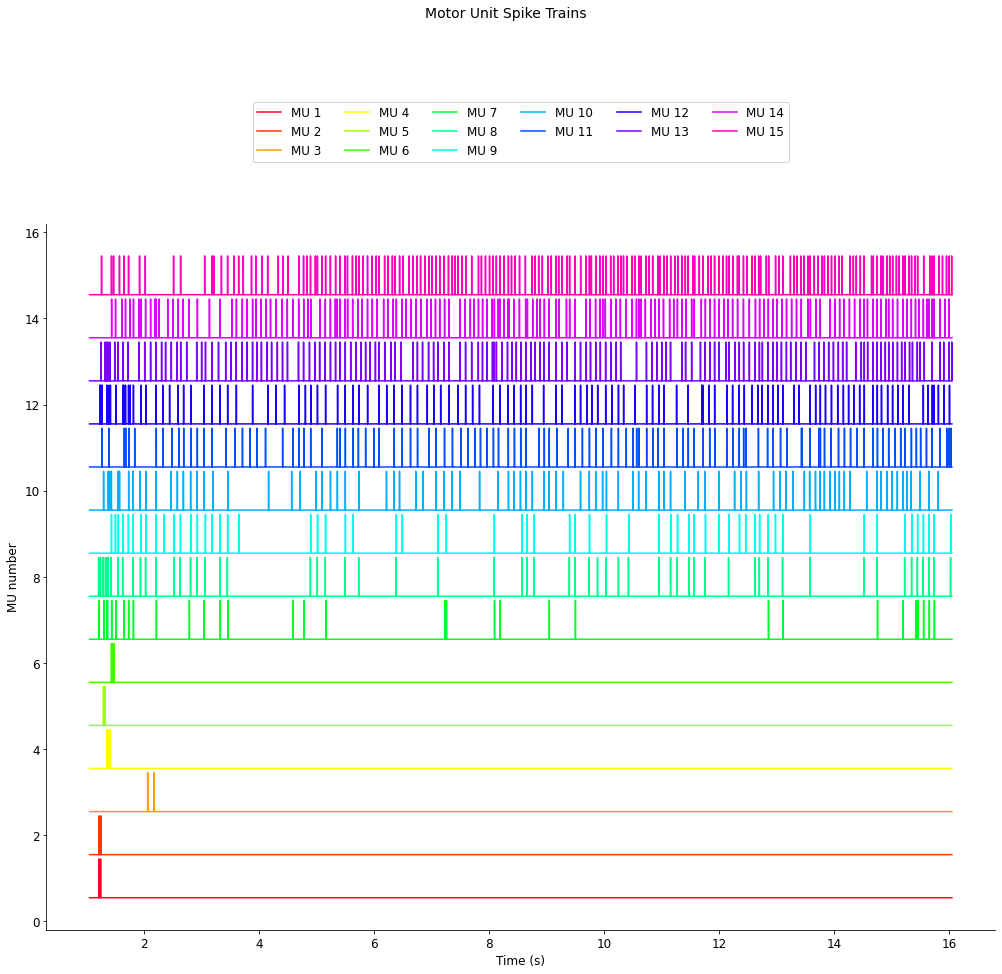

In [72]:
def plot_spikes(spike_trains):
    """
    Plots motor unit spike trains.

    Parameters:
    - spike_trains (numpy.ndarray): 2D array representing spike trains for each motor unit.

    Returns:
    None
    """

    # Generate a range of color markers based on the number of spike trains
    color_markers = plt.cm.gist_rainbow(np.linspace(0, 1, spike_trains.shape[0]))
    c_len = len(color_markers)

    # Create a figure with two subplots (spike trains and legend)
    fig, (lax, ax) = plt.subplots(figsize=(17, 15), nrows=2, gridspec_kw={"height_ratios": [1, 20]})

    # Plot each motor unit's spike train
    for i in range(spike_trains.shape[0]):
        ax.plot(time_samples, i + 0.55 + (0.9 * spike_trains[i, :]), c=color_markers[int(i % c_len)], label="MU " + str(i + 1))

    # Customize main plot
    plt.suptitle('Motor Unit Spike Trains', fontsize=14)
    plt.xlabel('Time (s)')
    plt.ylabel('MU number')

    # Customize legend subplot
    h, l = ax.get_legend_handles_labels()
    lax.legend(h, l, loc='center', borderaxespad=0, ncol=6)
    lax.axis("off")

# Example usage: Plot spike trains from extracted_PTs
plot_spikes(extracted_PTs)

## Further Reading

To enhance your understanding of EMG decomposition and analysis, we recommend exploring some [additional references](#scrollTo=aditional_references). A valuable starting point is [(DEL VECCHIO; HOLOBAR; FALLA; et al., 2020)](#scrollTo=aditional_references), a didactic paper that provides a step-by-step guide to the decomposition process and emphasizes essential considerations before, during, and after decomposition. While the manual inspection by the operator, as conducted in this workshop and proposed in [(DEL VECCHIO; HOLOBAR; FALLA; et al., 2020)](#scrollTo=aditional_references), may seem subjective, different experienced operators have consistently achieved similar results during manual evaluations [(HUG; AVRILLON; DEL VECCHIO; et al., 2021)](#scrollTo=aditional_references).

Additionally, [ENOKA (2019)](#scrollTo=aditional_references) and [FARINA and HOLOBAR (2016)](#scrollTo=aditional_references) support the application and validation of EMG decomposition techniques for identifying motor unit activities and studying their physiology. In [(HOLOBAR; FARINA, 2014)](#scrollTo=aditional_references), an overview is presented on applying blind source separation to multichannel EMG signals, where you can extract both motor unit discharge times and muscle synergies from the EMG. The section also discusses important considerations when applying BSS techniques to EMG signals.

As we has seen in these notebooks, several parameters require definition for the decomposition algorithm. In the study by [MENG, CHEN, JIANG, et al. (2022)](#scrollTo=aditional_references), various parameters for the FastICA algorithm in decomposing HD sEMG signals were evaluated. The study suggests trade-offs between time consumption and the number of identified motor units. Another established BSS technique and widely utilized for HD sEMG decomposition is the gradient convolution kernel compensation [(HOLOBAR; ZAZULA, 2007)](#scrollTo=aditional_references). Unlike ICA, this technique does not rely on the independence among source signals and does not estimate the separation matrix; instead, it directly estimates motor unit discharge times by maximizing uncorrelation.


## Funding

Part of this project was funded by [CNPq](http://www.cnpq.br/) (Brazilian National Science Foundation): proc. no. 131390/2021-0.

Part of this study was funded by [FAPESP](https://fapesp.br/) (São Paulo Research Foundation): proc. no. 2019/01508-4.

## References

1. HOLOBAR, A.; MINETTO, M. A.; FARINA, D. Accurate identification of motor unit discharge patterns from high-density surface EMG and validation with a novel signal-based performance metric. *Journal of Neural Engineering*, v. 11, n. 1, p. 016008, 2014. DOI: [10.1109/TSP.2007.896108](https://doi.org/10.1109/TSP.2007.896108).

2. HOLOBAR, A.; ZAZULA, D. On the selection of the cost function for gradient-based decomposition of surface electromyograms. *30th Annual International Conference of the IEEE Engineering in Medicine and Biology Society*, Vancouver, BC, Canada, n. 4, p. 4668–4671, 2008. DOI: [10.1109/iembs.2008.4650254](https://doi.org/10.1109/iembs.2008.4650254).

3. HOLOBAR, A.; MINETTO, M. A.; FARINA, D. Experimental Analysis of Accuracy in the Identification of Motor Unit Spike Trains From High-Density Surface EMG. *IEEE Transactions on Neural Systems and Rehabilitation Engineering*, v. 18, n. 3, p. 221–229, 2010. DOI: [10.1109/TNSRE.2010.2041593](https://doi.org/10.1109/TNSRE.2010.2041593).

4. HOLOBAR, A.; ZAZULA, D. Multichannel blind source separation using convolution Kernel compensation. *IEEE Transactions on Signal Processing*, v. 55, n. 9, p. 4487–4496, 2007. DOI: [10.1109/TSP.2007.896108](https://doi.org/10.1109/TSP.2007.896108).

5. HYVÄRINEN, A. Fast and robust fixed-point algorithms for independent component analysis. *IEEE Transactions on Neural Networks*, v. 10, n. 3, p. 626–634, 1999. DOI: [10.1109/72.761722](https://doi.org/10.1109/72.761722).

6. NEGRO, F.; MUCELI, S.; CASTRONOVO, A. M.; et al. Multi-channel intramuscular and surface EMG decomposition by convolutive blind source separation. *Journal of Neural Engineering*, v. 13, n. 2, p. 026027, 2016. DOI: [10.1088/1741-2560/13/2/026027](https://doi.org/10.1088/1741-2560/13/2/026027).

## Aditional References

7. DEL VECCHIO, A.; HOLOBAR, A.; FALLA, D.; et al. Tutorial: Analysis of motor unit discharge characteristics from high-density surface EMG signals. *Journal of Electromyography and Kinesiology*, vol. 53, p. 102426, 2020. DOI: [10.1016/j.jelekin.2020.102426](https://doi.org/10.1016/j.jelekin.2020.102426).

8. ENOKA, R. M. Physiological validation of the decomposition of surface EMG signals. *Journal of Electromyography and Kinesiology*, vol. 46, p. 70-83, 2019. DOI: [10.1016/j.jelekin.2019.03.010](https://doi.org/10.1016/j.jelekin.2019.03.010).

9. FARINA, D.; HOLOBAR, A. Characterization of Human Motor Units From Surface EMG Decomposition. *Proceedings of the IEEE*, vol. 104, no. 2, p. 353-373, 2016. DOI: [10.1109/JPROC.2015.2498665](https://doi.org/10.1109/JPROC.2015.2498665).

10. HOLOBAR, A.; FARINA, D. Blind source identification from the multichannel surface electromyogram. *Physiological Measurement*, vol. 35, no. 7, p. R143--R165, 2014. DOI: [10.1088/0967-3334/35/7/R143](https://doi.org/10.1088/0967-3334/35/7/R143).

11. HOLOBAR, A.; ZAZULA, D. Gradient Convolution Kernel Compensation Applied to Surface Electromyograms. *Independent Component Analysis and Signal Separation, ICA 2007. Lecture Notes in Computer Science*, vol 4666, p. 617–624, 2007. DOI: [10.1007/978-3-540-74494-8_77](https://doi.org/10.1007/978-3-540-74494-8_77).

12. HUG, F.; AVRILLON, S.; DEL VECCHIO, A.; et al. Analysis of motor unit spike trains estimated from high-density surface electromyography is highly reliable across operators. *Journal of Electromyography and Kinesiology*, v. 58, p. 102548, 2021. DOI: [10.1016/j.jelekin.2021.102548](https://doi.org/10.1016/j.jelekin.2021.102548).

13. MENG, L.; CHEN, Q.; JIANG, X.; et al. Evaluation of decomposition parameters for high-density surface electromyogram using fast independent component analysis algorithm. *Biomedical Signal Processing and Control*, v. 75, p. 103615, 2022. DOI: [10.1016/j.bspc.2022.103615](https://doi.org/10.1016/j.bspc.2022.103615).